### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [1]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, DATASET_PATH_TYPE
from src.utils.augmentation import erase_generator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [2]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [3]:
CHECKPOINT_PATH = get_checkpoint_path("sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

In [4]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    pred_iou_thresh=0.99,
    stability_score_thresh=0.99,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [5]:
def remove_shadow_rgb(image):
    # Convert image to RGB if it isn't already
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if image.shape[-1] == 3 else image
    # Convert to YCrCb color space
    ycrcb = cv2.cvtColor(rgb, cv2.COLOR_RGB2YCrCb)
    # Split into channels
    y, cr, cb = cv2.split(ycrcb)
    # Apply histogram equalization on the brightness channel
    y_eq = cv2.equalizeHist(y)
    # Merge back the channels
    ycrcb_eq = cv2.merge((y_eq, cr, cb))
    # Convert back to RGB
    result = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2RGB)
    return result

1


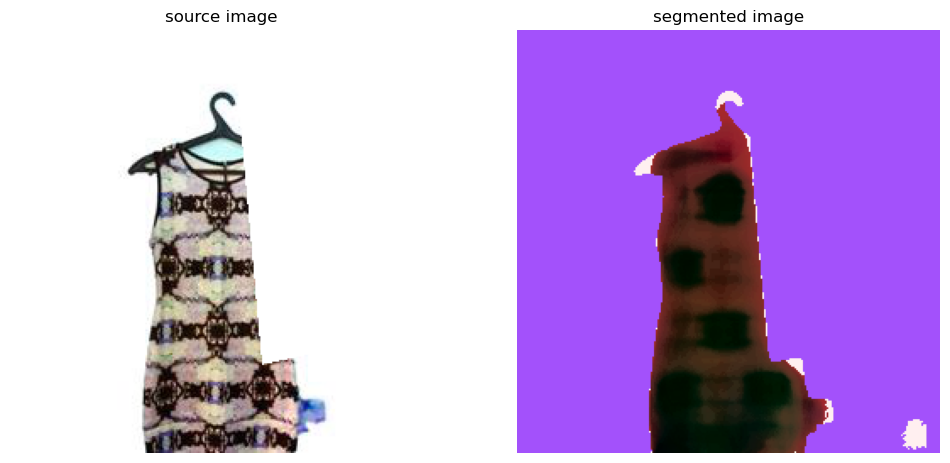

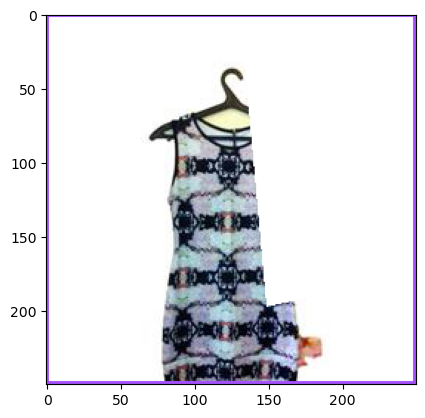

In [42]:
import cv2
import numpy as np

relative_path = get_training_data_path('classifier', 'dress')

file_names = []

# Walk through all files and directories recursively
for root, dirs, files in os.walk(relative_path):
    # Iterate over files in the current directory
    for i in range(1, 2):
        fullpath = os.path.join(relative_path, files[i])

        orig_image = cv2.imread(fullpath)

        image = erase_generator(path=fullpath)
        n_image = np.array(image)
        # Convert image to YCrCb color space, then apply blurring and shadow removal
        image_ycrcb = cv2.cvtColor(n_image, cv2.COLOR_BGR2YCrCb)


        blurred_image = cv2.medianBlur(image_ycrcb, 25)
        processed_image = remove_shadow_rgb(blurred_image)  # Assuming remove_shadow_rgb can handle YCrCb images

        # Generate masks and filter them
        masks = mask_generator.generate(image_ycrcb)
        print(len(masks))
        cleaned_masks = [mask for mask in masks if mask['area'] > 1000]

        # Annotation of the image
        mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX, opacity=1.0)
        detections = sv.Detections.from_sam(sam_result=cleaned_masks)
        annotated_image = mask_annotator.annotate(scene=processed_image.copy(), detections=detections)
        
        # Displaying images
        sv.plot_images_grid(
            images=[n_image, annotated_image],
            grid_size=(1, 2),
            titles=['source image', 'segmented image']
        )

        # Bounding box annotation on the original image for consistency
        bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
        final_annotated_image = bounding_box_annotator.annotate(
            scene=image, detections=detections)

        plt.imshow(final_annotated_image)

In [39]:
masks_cleaned = []
print(len(masks))
for mask in masks: 
    if np.mean(mask['segmentation'][3]) <= 0.2 and (mask['area'] >= 1000 and mask['area'] <= 200000):
        masks_cleaned.append(mask)

masked_image = n_image
for mask in masks_cleaned:
    x, y, w, h = mask['bbox']
    cv2.rectangle(masked_image, (x, y), (x + w, y + h), (0, 255,0), 3)

plt.imshow(masked_image)

1


error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2
